In [1]:
#Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Conv1D, MaxPooling1D, UpSampling1D, Reshape, Flatten, Lambda, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

In [2]:
#Cell 2
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    if num_files_to_use:
        svc_files = random.sample(svc_files, num_files_to_use)

    data_frames = []
    scalers = []

    for filename in svc_files:
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        df = df.iloc[:, [0, 1, 3]]  # Select x, y, and pen_status
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y']])  # Normalize x and y only
        normalized_data = np.column_stack((normalized_data, df['pen_status']))  # Add pen_status back to the normalized data
        scalers.append(scaler)

    combined_data = np.vstack([np.column_stack((scaler.transform(df[['x', 'y']]), df['pen_status'])) for df, scaler in zip(data_frames, scalers)])
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, combined_data, scalers, avg_data_points

directory = 'Task6'  # Directory where the .svc files are stored
data_frames, combined_data, scalers, avg_data_points = upload_and_process_files(directory, num_files_to_use=50)
print(f"Processed data shape: {combined_data.shape}")
print(f"Average number of data points: {avg_data_points}")

# Split the data into training and validation sets
train_data, val_data = train_test_split(combined_data, test_size=0.2, random_state=42)

C:\Users\annek\AppData\Local\Temp\ipykernel_18264\2917157151.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\annek\AppData\Local\Temp\ipykernel_18264\2917157151.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\annek\AppData\Local\Temp\ipykernel_18264\2917157151.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\annek\AppData\Local\Temp\ipykernel_18264\2917157151.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is depr

Processed data shape: (211464, 3)
Average number of data points: 4229


In [3]:
#Cell 3
class ImprovedVAE(Model):
    def __init__(self, latent_dim):
        super(ImprovedVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()

    def build_encoder(self):
        inputs = Input(shape=(3,))
        x = Reshape((3, 1))(inputs)
        x = Conv1D(32, 3, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv1D(64, 3, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Flatten()(x)
        x = Dense(128, activation='relu')(x)
        x = BatchNormalization()(x)
        
        z_mean = Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = Dense(self.latent_dim, name='z_log_var')(x)
        
        return Model(inputs, [z_mean, z_log_var], name='encoder')

    def build_decoder(self):
        latent_inputs = Input(shape=(self.latent_dim,))
        x = Dense(128, activation='relu')(latent_inputs)
        x = BatchNormalization()(x)
        x = Dense(3 * 64, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Reshape((3, 64))(x)
        x = Conv1D(32, 3, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv1D(1, 3, activation='sigmoid', padding='same')(x)
        outputs = Flatten()(x)
        
        return Model(latent_inputs, outputs, name='decoder')

    def reparameterize(self, z_mean, z_log_var):
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstruction = self.decoder(z)
        return reconstruction, z_mean, z_log_var

latent_dim = 32
vae = ImprovedVAE(latent_dim)


In [4]:
#Cell 4
def compute_loss(model, x):
    reconstruction, z_mean, z_log_var = model(x)
    reconstruction_loss = tf.reduce_mean(
        tf.keras.losses.mse(x, reconstruction)
    )
    kl_loss = -0.5 * tf.reduce_mean(
        1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    )
    total_loss = reconstruction_loss + kl_loss
    return total_loss, reconstruction_loss, kl_loss

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function
def train_step(model, x):
    with tf.GradientTape() as tape:
        total_loss, reconstruction_loss, kl_loss = compute_loss(model, x)
    grads = tape.gradient(total_loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return total_loss, reconstruction_loss, kl_loss

def validate(model, x):
    total_loss, reconstruction_loss, kl_loss = compute_loss(model, x)
    return total_loss, reconstruction_loss, kl_loss


Epoch 1/200


Training: 100%|██████████| 2644/2644 [00:35<00:00, 73.83it/s] 


Training Loss: 0.0737
Reconstruction Loss: 0.0434
KL Loss: 0.0303


Validation: 100%|██████████| 661/661 [00:41<00:00, 15.81it/s]


Validation Loss: 0.0686
Reconstruction Loss: 0.0341
KL Loss: 0.0345

Epoch 2/200


Training: 100%|██████████| 2644/2644 [00:23<00:00, 112.29it/s]


Training Loss: 0.0683
Reconstruction Loss: 0.0349
KL Loss: 0.0334


Validation: 100%|██████████| 661/661 [00:45<00:00, 14.39it/s]


Validation Loss: 0.0678
Reconstruction Loss: 0.0335
KL Loss: 0.0343

Epoch 3/200


Training: 100%|██████████| 2644/2644 [00:23<00:00, 113.38it/s]


Training Loss: 0.0679
Reconstruction Loss: 0.0334
KL Loss: 0.0345


Validation: 100%|██████████| 661/661 [00:46<00:00, 14.28it/s]


Validation Loss: 0.0672
Reconstruction Loss: 0.0327
KL Loss: 0.0345

Epoch 4/200


Training: 100%|██████████| 2644/2644 [00:21<00:00, 120.36it/s]


Training Loss: 0.0675
Reconstruction Loss: 0.0324
KL Loss: 0.0350


Validation: 100%|██████████| 661/661 [00:45<00:00, 14.43it/s]


Validation Loss: 0.0674
Reconstruction Loss: 0.0347
KL Loss: 0.0327

Epoch 5/200


Training: 100%|██████████| 2644/2644 [00:21<00:00, 120.24it/s]


Training Loss: 0.0675
Reconstruction Loss: 0.0322
KL Loss: 0.0353


Validation: 100%|██████████| 661/661 [00:38<00:00, 17.35it/s]


Validation Loss: 0.0674
Reconstruction Loss: 0.0317
KL Loss: 0.0356

Epoch 6/200


Training: 100%|██████████| 2644/2644 [00:21<00:00, 123.78it/s]


Training Loss: 0.0672
Reconstruction Loss: 0.0321
KL Loss: 0.0351


Validation: 100%|██████████| 661/661 [00:36<00:00, 17.97it/s]


Validation Loss: 0.0677
Reconstruction Loss: 0.0313
KL Loss: 0.0364

Epoch 7/200


Training: 100%|██████████| 2644/2644 [00:24<00:00, 108.26it/s]


Training Loss: 0.0673
Reconstruction Loss: 0.0319
KL Loss: 0.0354


Validation: 100%|██████████| 661/661 [00:40<00:00, 16.25it/s]


Validation Loss: 0.0672
Reconstruction Loss: 0.0316
KL Loss: 0.0356

Epoch 8/200


Training: 100%|██████████| 2644/2644 [00:22<00:00, 116.42it/s]


Training Loss: 0.0673
Reconstruction Loss: 0.0321
KL Loss: 0.0353


Validation: 100%|██████████| 661/661 [00:40<00:00, 16.30it/s]


Validation Loss: 0.0675
Reconstruction Loss: 0.0335
KL Loss: 0.0340

Epoch 9/200


Training: 100%|██████████| 2644/2644 [00:24<00:00, 106.38it/s]


Training Loss: 0.0673
Reconstruction Loss: 0.0318
KL Loss: 0.0354


Validation: 100%|██████████| 661/661 [00:38<00:00, 17.05it/s]


Validation Loss: 0.0671
Reconstruction Loss: 0.0314
KL Loss: 0.0357

Epoch 10/200


Training: 100%|██████████| 2644/2644 [00:20<00:00, 131.26it/s]


Training Loss: 0.0672
Reconstruction Loss: 0.0318
KL Loss: 0.0354


Validation: 100%|██████████| 661/661 [00:37<00:00, 17.42it/s]


Validation Loss: 0.0673
Reconstruction Loss: 0.0310
KL Loss: 0.0363

Epoch 11/200


Training: 100%|██████████| 2644/2644 [00:20<00:00, 131.20it/s]


Training Loss: 0.0672
Reconstruction Loss: 0.0318
KL Loss: 0.0354


Validation: 100%|██████████| 661/661 [00:36<00:00, 18.00it/s]


Validation Loss: 0.0675
Reconstruction Loss: 0.0332
KL Loss: 0.0343

Epoch 12/200


Training: 100%|██████████| 2644/2644 [00:20<00:00, 129.71it/s]


Training Loss: 0.0672
Reconstruction Loss: 0.0317
KL Loss: 0.0355


Validation: 100%|██████████| 661/661 [00:39<00:00, 16.94it/s]


Validation Loss: 0.0676
Reconstruction Loss: 0.0337
KL Loss: 0.0339

Epoch 13/200


Training: 100%|██████████| 2644/2644 [00:21<00:00, 123.53it/s]


Training Loss: 0.0670
Reconstruction Loss: 0.0313
KL Loss: 0.0358


Validation: 100%|██████████| 661/661 [00:43<00:00, 15.24it/s]


Validation Loss: 0.0669
Reconstruction Loss: 0.0322
KL Loss: 0.0346

Epoch 14/200


Training: 100%|██████████| 2644/2644 [00:21<00:00, 124.69it/s]


Training Loss: 0.0669
Reconstruction Loss: 0.0305
KL Loss: 0.0364


Validation: 100%|██████████| 661/661 [00:38<00:00, 17.30it/s]


Validation Loss: 0.0665
Reconstruction Loss: 0.0301
KL Loss: 0.0364

Epoch 15/200


Training: 100%|██████████| 2644/2644 [00:21<00:00, 123.17it/s]


Training Loss: 0.0669
Reconstruction Loss: 0.0302
KL Loss: 0.0367


Validation: 100%|██████████| 661/661 [00:40<00:00, 16.43it/s]


Validation Loss: 0.0664
Reconstruction Loss: 0.0306
KL Loss: 0.0358

Epoch 16/200


Training: 100%|██████████| 2644/2644 [00:21<00:00, 124.61it/s]


Training Loss: 0.0667
Reconstruction Loss: 0.0297
KL Loss: 0.0370


Validation: 100%|██████████| 661/661 [00:39<00:00, 16.84it/s]


Validation Loss: 0.0670
Reconstruction Loss: 0.0291
KL Loss: 0.0378

Epoch 17/200


Training: 100%|██████████| 2644/2644 [00:23<00:00, 110.26it/s]


Training Loss: 0.0668
Reconstruction Loss: 0.0299
KL Loss: 0.0370


Validation: 100%|██████████| 661/661 [00:38<00:00, 16.96it/s]


Validation Loss: 0.0668
Reconstruction Loss: 0.0290
KL Loss: 0.0378

Epoch 18/200


Training: 100%|██████████| 2644/2644 [00:24<00:00, 109.19it/s]


Training Loss: 0.0668
Reconstruction Loss: 0.0302
KL Loss: 0.0366


Validation: 100%|██████████| 661/661 [00:46<00:00, 14.25it/s]


Validation Loss: 0.0665
Reconstruction Loss: 0.0303
KL Loss: 0.0362

Epoch 19/200


Training: 100%|██████████| 2644/2644 [00:27<00:00, 97.17it/s] 


Training Loss: 0.0667
Reconstruction Loss: 0.0300
KL Loss: 0.0368


Validation: 100%|██████████| 661/661 [00:58<00:00, 11.32it/s]


Validation Loss: 0.0666
Reconstruction Loss: 0.0300
KL Loss: 0.0366

Epoch 20/200


Training: 100%|██████████| 2644/2644 [00:26<00:00, 98.37it/s] 


Training Loss: 0.0667
Reconstruction Loss: 0.0297
KL Loss: 0.0370


Validation: 100%|██████████| 661/661 [00:47<00:00, 13.84it/s]


Validation Loss: 0.0669
Reconstruction Loss: 0.0302
KL Loss: 0.0367

Epoch 21/200


Training: 100%|██████████| 2644/2644 [00:28<00:00, 93.62it/s] 


Training Loss: 0.0666
Reconstruction Loss: 0.0296
KL Loss: 0.0370


Validation: 100%|██████████| 661/661 [00:53<00:00, 12.33it/s]


Validation Loss: 0.0667
Reconstruction Loss: 0.0299
KL Loss: 0.0368

Epoch 22/200


Training: 100%|██████████| 2644/2644 [00:25<00:00, 102.60it/s]


Training Loss: 0.0668
Reconstruction Loss: 0.0296
KL Loss: 0.0372


Validation: 100%|██████████| 661/661 [00:53<00:00, 12.47it/s]


Validation Loss: 0.0665
Reconstruction Loss: 0.0290
KL Loss: 0.0375

Epoch 23/200


Training: 100%|██████████| 2644/2644 [00:25<00:00, 102.40it/s]


Training Loss: 0.0666
Reconstruction Loss: 0.0297
KL Loss: 0.0369


Validation: 100%|██████████| 661/661 [00:52<00:00, 12.49it/s]


Validation Loss: 0.0667
Reconstruction Loss: 0.0297
KL Loss: 0.0370

Epoch 24/200


Training: 100%|██████████| 2644/2644 [00:28<00:00, 91.25it/s] 


Training Loss: 0.0668
Reconstruction Loss: 0.0298
KL Loss: 0.0369


Validation: 100%|██████████| 661/661 [00:48<00:00, 13.57it/s]


Validation Loss: 0.0668
Reconstruction Loss: 0.0294
KL Loss: 0.0373

Epoch 25/200


Training: 100%|██████████| 2644/2644 [00:27<00:00, 95.73it/s] 


Training Loss: 0.0668
Reconstruction Loss: 0.0298
KL Loss: 0.0370


Validation: 100%|██████████| 661/661 [00:45<00:00, 14.67it/s]


Validation Loss: 0.0667
Reconstruction Loss: 0.0279
KL Loss: 0.0388

Epoch 26/200


Training: 100%|██████████| 2644/2644 [00:25<00:00, 101.91it/s]


Training Loss: 0.0667
Reconstruction Loss: 0.0297
KL Loss: 0.0370


Validation: 100%|██████████| 661/661 [00:46<00:00, 14.14it/s]


Validation Loss: 0.0669
Reconstruction Loss: 0.0284
KL Loss: 0.0385

Epoch 27/200


Training: 100%|██████████| 2644/2644 [00:26<00:00, 100.98it/s]


Training Loss: 0.0667
Reconstruction Loss: 0.0294
KL Loss: 0.0373


Validation: 100%|██████████| 661/661 [00:46<00:00, 14.28it/s]


Validation Loss: 0.0670
Reconstruction Loss: 0.0306
KL Loss: 0.0364

Epoch 28/200


Training: 100%|██████████| 2644/2644 [00:26<00:00, 99.20it/s] 


Training Loss: 0.0668
Reconstruction Loss: 0.0297
KL Loss: 0.0371


Validation: 100%|██████████| 661/661 [00:48<00:00, 13.67it/s]


Validation Loss: 0.0667
Reconstruction Loss: 0.0311
KL Loss: 0.0356

Epoch 29/200


Training: 100%|██████████| 2644/2644 [00:29<00:00, 90.21it/s] 


Training Loss: 0.0667
Reconstruction Loss: 0.0295
KL Loss: 0.0372


Validation: 100%|██████████| 661/661 [00:47<00:00, 13.88it/s]


Validation Loss: 0.0668
Reconstruction Loss: 0.0280
KL Loss: 0.0388

Epoch 30/200


Training: 100%|██████████| 2644/2644 [00:26<00:00, 97.99it/s] 


Training Loss: 0.0667
Reconstruction Loss: 0.0296
KL Loss: 0.0371


Validation: 100%|██████████| 661/661 [00:44<00:00, 14.75it/s]


Validation Loss: 0.0669
Reconstruction Loss: 0.0289
KL Loss: 0.0379

Epoch 31/200


Training: 100%|██████████| 2644/2644 [00:26<00:00, 99.29it/s] 


Training Loss: 0.0666
Reconstruction Loss: 0.0295
KL Loss: 0.0371


Validation: 100%|██████████| 661/661 [00:49<00:00, 13.44it/s]


Validation Loss: 0.0668
Reconstruction Loss: 0.0312
KL Loss: 0.0355

Epoch 32/200


Training: 100%|██████████| 2644/2644 [00:27<00:00, 96.35it/s] 


Training Loss: 0.0668
Reconstruction Loss: 0.0297
KL Loss: 0.0371


Validation: 100%|██████████| 661/661 [00:49<00:00, 13.32it/s]


Validation Loss: 0.0668
Reconstruction Loss: 0.0293
KL Loss: 0.0375

Epoch 33/200


Training: 100%|██████████| 2644/2644 [00:27<00:00, 94.91it/s] 


Training Loss: 0.0667
Reconstruction Loss: 0.0295
KL Loss: 0.0373


Validation: 100%|██████████| 661/661 [00:47<00:00, 13.83it/s]


Validation Loss: 0.0670
Reconstruction Loss: 0.0291
KL Loss: 0.0379

Epoch 34/200


Training: 100%|██████████| 2644/2644 [00:27<00:00, 96.24it/s] 


Training Loss: 0.0666
Reconstruction Loss: 0.0294
KL Loss: 0.0372


Validation: 100%|██████████| 661/661 [00:50<00:00, 13.16it/s]


Validation Loss: 0.0674
Reconstruction Loss: 0.0273
KL Loss: 0.0401

Epoch 35/200


Training: 100%|██████████| 2644/2644 [00:27<00:00, 95.53it/s] 


Training Loss: 0.0665
Reconstruction Loss: 0.0295
KL Loss: 0.0369


Validation: 100%|██████████| 661/661 [00:49<00:00, 13.34it/s]


Validation Loss: 0.0669
Reconstruction Loss: 0.0313
KL Loss: 0.0357
Early stopping at epoch 35
Training completed.


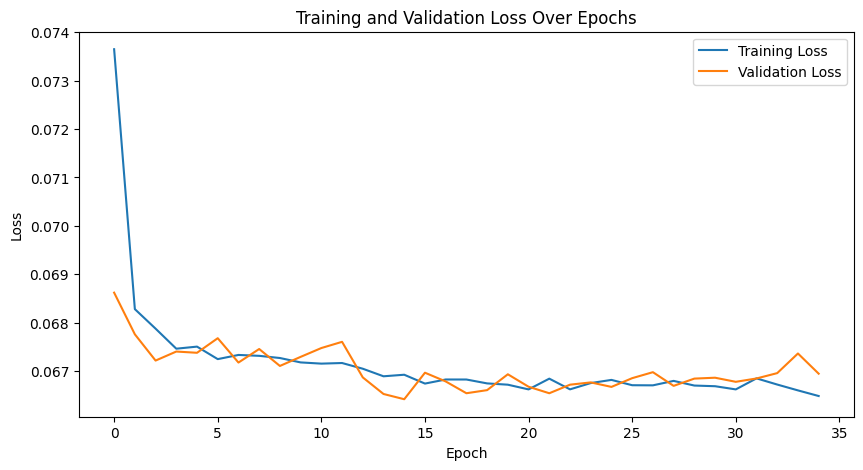

In [5]:
#Cell 5
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(10000).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices(val_data).batch(batch_size)

epochs = 200
early_stopping_patience = 20
min_delta = 0.0001
best_val_loss = float('inf')
patience_counter = 0

train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    
    # Training
    train_total_loss = 0
    train_reconstruction_loss = 0
    train_kl_loss = 0
    num_batches = 0
    
    for batch in tqdm(train_dataset, desc="Training"):
        batch_loss, batch_reconstruction_loss, batch_kl_loss = train_step(vae, batch)
        train_total_loss += batch_loss
        train_reconstruction_loss += batch_reconstruction_loss
        train_kl_loss += batch_kl_loss
        num_batches += 1
    
    train_total_loss /= num_batches
    train_reconstruction_loss /= num_batches
    train_kl_loss /= num_batches
    train_loss_history.append(train_total_loss)
    
    print(f"Training Loss: {train_total_loss:.4f}")
    print(f"Reconstruction Loss: {train_reconstruction_loss:.4f}")
    print(f"KL Loss: {train_kl_loss:.4f}")
    
    # Validation
    val_total_loss = 0
    val_reconstruction_loss = 0
    val_kl_loss = 0
    num_batches = 0
    
    for batch in tqdm(val_dataset, desc="Validation"):
        batch_loss, batch_reconstruction_loss, batch_kl_loss = validate(vae, batch)
        val_total_loss += batch_loss
        val_reconstruction_loss += batch_reconstruction_loss
        val_kl_loss += batch_kl_loss
        num_batches += 1
    
    val_total_loss /= num_batches
    val_reconstruction_loss /= num_batches
    val_kl_loss /= num_batches
    val_loss_history.append(val_total_loss)
    
    print(f"Validation Loss: {val_total_loss:.4f}")
    print(f"Reconstruction Loss: {val_reconstruction_loss:.4f}")
    print(f"KL Loss: {val_kl_loss:.4f}")
    
    if val_total_loss < best_val_loss - min_delta:
        best_val_loss = val_total_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

print("Training completed.")

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


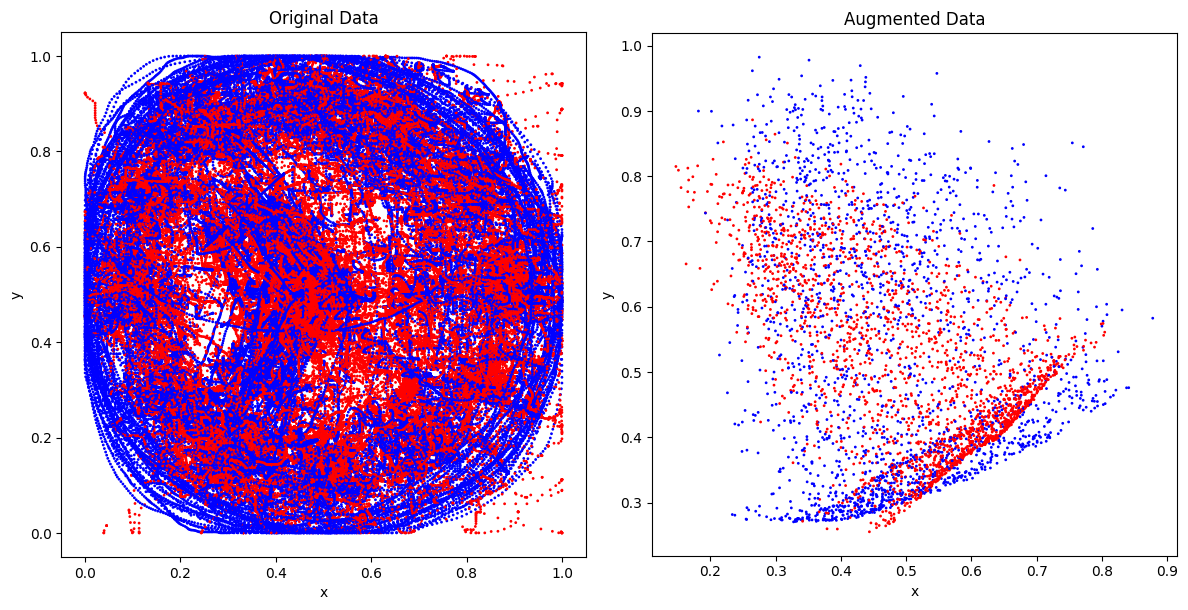

ValueError: Found input variables with inconsistent numbers of samples: [211464, 4229]

In [6]:
def generate_augmented_data(model, num_samples, variability=0.1):
    z = tf.random.normal(shape=(num_samples, latent_dim))
    augmented_data = model.decoder(z).numpy()
    
    # Apply thresholding to pen_status
    augmented_data[:, 2] = (augmented_data[:, 2] > 0.5).astype(float)
    
    return augmented_data

num_augmented_samples = avg_data_points
augmented_data = generate_augmented_data(vae, num_augmented_samples)

# Visualize the original and augmented data side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(combined_data[:, 0], combined_data[:, 1], c=['red' if status == 0 else 'blue' for status in combined_data[:, 2]], s=1)
axs[0].set_title('Original Data')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_aspect('equal')

axs[1].scatter(augmented_data[:, 0], augmented_data[:, 1], c=['red' if status == 0 else 'blue' for status in augmented_data[:, 2]], s=1)
axs[1].set_title('Augmented Data')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# Calculate metrics
mae = mean_absolute_error(combined_data, augmented_data)
mse = mean_squared_error(combined_data, augmented_data)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(combined_data, augmented_data)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Percentage Error: {mape:.4f}")